In [ ]:
#|hide
#|default_exp lesson12

# Lesson 12 - Introduction to Diffusion Models

Diffusion models are a little different to the other types of generative models you may have encountered. During training, input images (or any other kind of data) are corrupted, and the model attempts to 'undo' this corruption. Once trained, we can begin from a random set of inputs that resembles data that has been so completely degraded as to be unrecognizeable and then gradually 'uncorrupt' this, typically over a large number of steps.

TODO diagram

In most (but not all!) current approaches, this 'corruption' takes the place of adding noise, hence 'denoising diffusion models'. The exact method of adding noise and the details of how the problem is formulated vary across the literature, which can lead to confusion.

The goal of this lesson is to introduce the key concepts without worrying too much about specific implementations. The plan:

- Start with a simplistic toy example
- Discuss some issues with it, and try a few improvements
- Try an existing implementation, exploring the differences between this and our toy version
- Along the way we'll define some key terms and highlight some additional questions that will be addressed in later lessons. Ready? Let's go!

In [ ]:
#|hide
#|export
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tglcourse.data_utils import get_mnist_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## A Toy Example

![toy photo](https://images.pexels.com/photos/12211/pexels-photo-12211.jpeg?cs=srgb&dl=pexels-tetyana-kovyrina-12211.jpg&fm=jpg&w=640&h=427)

[video: intro idea]

Load the dataset (replace MNIST with FashionMNIST for a variant):

In [ ]:
#!output: false
mnist_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Viewing the first example image:

Image shape: torch.Size([1, 28, 28])
Image min and max: tensor(0.) tensor(1.)
label: 5


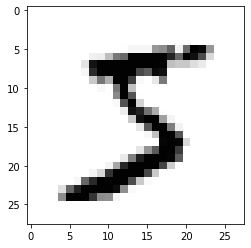

In [ ]:
# View an example
im, label = mnist_dataset[0]
print('Image shape:', im.shape)
print('Image min and max:', im.min(), im.max())
print('label:', label)
plt.imshow(im[0], cmap='Greys');

In [ ]:
# See how we can make a dataloader to serve the data in batches for training
train_dataloader = DataLoader(mnist_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
x.shape, y

(torch.Size([8, 1, 28, 28]), tensor([5, 5, 9, 2, 1, 0, 1, 6]))

### The Corruption Process

Pretend you haven't read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add, and then we do:

`noise = torch.rand_like(x)` 

`noisy_x =  (1-amount)*x + amount*noise`

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don't get burnt by broadcasting rules): 

In [ ]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount 

And looking at the results visually to see that it works as expected:

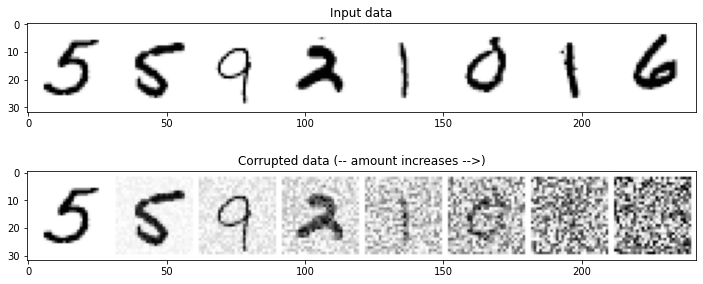

In [ ]:
#|echo: false
# Visualize the process
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

axs[1].set_title('Corrupted data (-- amount increases -->)')
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

With this in place, let's move on to the next piece of this process - the model.

### The Model (take 1)

Sticking with our goal of simplicity, we'll specify the model here as a neural network that produces an output the same shape as it's input. I've made three variants you can try out:

In [ ]:
#|code-fold:true
#|export
class BasicConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        padding = kernel_size // 2 # So we keep output size the same
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size, padding=padding),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#|code-fold:true
#|export
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


def MLPMixer(*, image_size, channels, patch_size, dim, depth, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    # Get image width and height (same if image_size isn't a tuple):
    pair = lambda x: x if isinstance(x, tuple) else (x, x)
    image_h, image_w = pair(image_size)
    # Check they divide neatly by patch_size
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    # Prep the two layers
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear
    # Return the model (a stack of [FeedForward(chan_first), FeedForward(chan_last)] pairs
    # with layer norm on the inputs and a skip connection thanks to PreNormResidual)
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', h = int(image_h/patch_size),  w = int(image_w/patch_size), p1 = patch_size, p2 = patch_size),
        nn.Conv2d(dim//(patch_size**2), channels, kernel_size=1) # Back to right number of channels
    )

In [ ]:
#|code-fold:show
#|export
class BasicUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Our list of layers, ina ModuleList so they show up as parameters
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            h.append(x)
            if i < 2: x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0: x = self.upscale(x)
            x += h.pop()
            x = self.act(l(x))
        return x

In [ ]:
unet = BasicUNet(1, 2)
unet(torch.rand(8, 1, 28, 28)).shape

torch.Size([8, 2, 28, 28])

In [ ]:
sum([p.numel() for p in unet.parameters()]) # Try halving the number of channels in each layer

309858

TODO show doc

We can create one and feed our demo batch of data through to check that it works and that the output shape is the same as the input as we expect:

In [ ]:
# Create the network (for single channel input & output images)
net = BasicUNet(1, 1)

# Feed some data through:
x.shape, net(x).shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

# Training the network

So what should the model do, exactly? Again, there are various takes on this but for this demo let's pick a simple framing: given a corrupted input noisy_x the model should output its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error

We can now have a go at training the network. 
- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.

Feel free to experiment with all of the parameters here - for this example I chose most fairly arbitrarily!

Finished epoch 0. Average of the last 100 loss values: 0.021335
Finished epoch 1. Average of the last 100 loss values: 0.019180
Finished epoch 2. Average of the last 100 loss values: 0.018072
Finished epoch 3. Average of the last 100 loss values: 0.017523
Finished epoch 4. Average of the last 100 loss values: 0.017608
Finished epoch 5. Average of the last 100 loss values: 0.016364
Finished epoch 6. Average of the last 100 loss values: 0.016416
Finished epoch 7. Average of the last 100 loss values: 0.016139
Finished epoch 8. Average of the last 100 loss values: 0.015554
Finished epoch 9. Average of the last 100 loss values: 0.016245


[<matplotlib.lines.Line2D>]

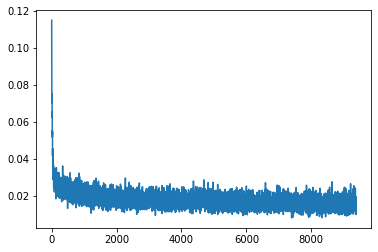

In [ ]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network (feel free to explore)
# net = BasicConvNet(1, 1)
# net = MLPMixer(image_size=28, channels=1, patch_size=4, dim=64, depth=4)
net = BasicUNet(1, 1)
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_basic = []

# The training loop
for epoch in range(n_epochs):
    
    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        
        # break

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_basic.append(avg_loss)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it my different amounts and then seeing the models predictions:

<matplotlib.image.AxesImage>

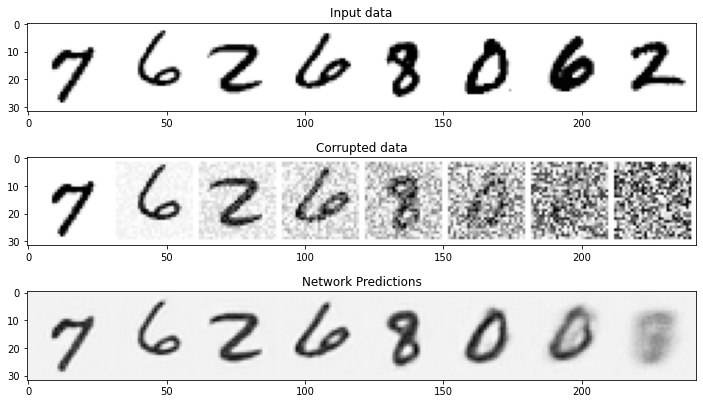

In [ ]:
#|code-fold:true
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')

You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs something close to the mean of the dataset to try and hedge its bets on what the output might look like.

**Think**: Does that final sentence make sense?

# Sampling

As we just saw, feeding pure noise into the model doesn't give a prediction that looks much like a digit! We need a sampling strategy. Again, pretend we're trying this without peeking at any existing papers and that the words 'differential equation' are an alien language. 

When the model sees a very corrupted input it doesn't have much information to go on, but perhaps there's a darker region that might indicate some ink near the top - perhaps a 7 or a 5. For an image with less noise, perhaps more structure becomes clear - a 5 or perhaps an 8? Based on this, perhaps we can gradually approach the goal? Let's think about it through an analogy:

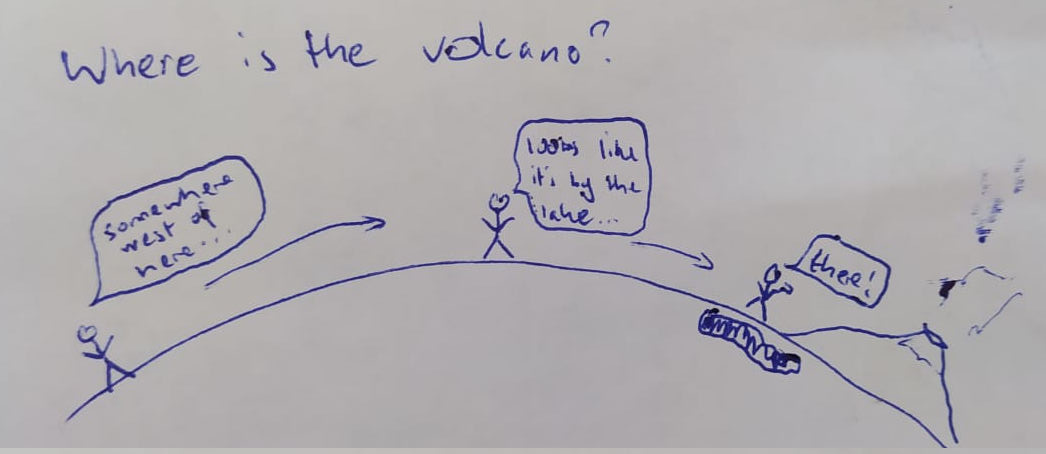

In [ ]:
#|hide
from tglcourse.utils import load_image_pil
load_image_pil('images/volcano_sketch.jpeg')

[placeholder image]

There's a cool volcano explosion happening somewhere, and you want to visit it and take photos. You look around, and the western horizon seems darker. You head that way, and even though you didn't quite guess the exact direction right, when you next park the car and look around you can see some hazy hills by a lake in the distance. It looks like one of them is the source of the smoke. As you pull up near the water, it is clear which hill is covered in lava, and how far away it is. Out comes the camera and you get a journalism prize.

Far fetched perhaps, but let's translate this back to the problem at hand and see if we get anywhere:

- The model predictions for high noise amounts aren't great, but might at least partly show us a fruitful direction to explore. 
- If we just move a little in that direction, we should then be able to make a better prediction and move a bit closer...
- Repeat this enough and hopefully we'll get a good result!

Putting it in pseudo-code:
```
steps = 10
x = random noise to start
for i in range(steps):
  pred = model(x)
  x = a mix of x and pred
```

And in code, visualizing the steps and model outputs along the way:

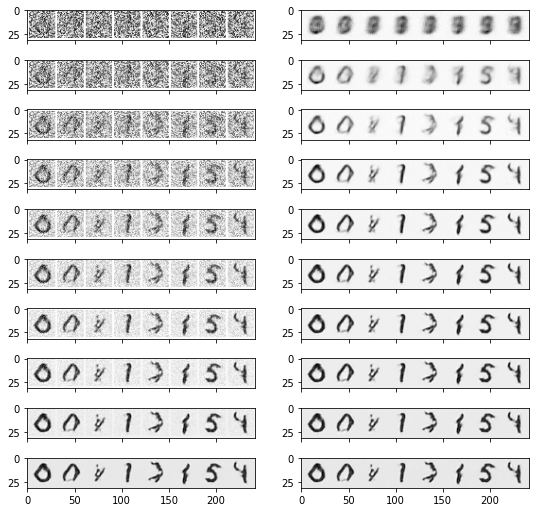

In [ ]:
# Take one: just break the process into 10 steps and move 1/10'th of the way there each time:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')


The left-hand column shows the steps after each update, while the right shows the model's predictions for the fully denoised image given the noisy input. You can see the general structure appears quite soon in the process.

### Making the model's job easier: Noise Conditioning

At the moment the model gets a noisy_x and tries to predict the original just based on that. It seems intuitive that if we can find a way to slip the model extra info in the form of a hint, it should be able to do a better job. So, to start with, let's make a version that can receive info about how much noise has been added:

In [ ]:
#|export
#|code-fold:true
class NoiseConditionedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = BasicUNet(in_channels+1, out_channels)

    def forward(self, x, noise_amount):
        # Shape of x
        bs, ch, w, h = x.shape
        
        # Get noise_amount as a single channel 'image' the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h) # If x.shape is [8,3,28,28] noise_amount is [8,1,28, 28]
        
        # Concatenate this onto x to get the final net input:
        net_input = torch.cat((x, noise_amount), 1)
        
        # Now pass through the net to get the prediction as before
        return self.net(net_input)

In [ ]:
# Creating a network
net = NoiseConditionedUNet(1, 1)

# Now we need both x and noise_amount to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

All we do here in add a second channel to the input image with the noise amount as the value for all 'pixels'. The training looks identical to before except we use our new network and must pass the noise amount as a second argument to the forward pass with `pred = net(noisy_x, noise_amount)`:

Finished epoch 0. Average of the last 100 loss values: 0.021807
Finished epoch 1. Average of the last 100 loss values: 0.019406
Finished epoch 2. Average of the last 100 loss values: 0.018026
Finished epoch 3. Average of the last 100 loss values: 0.017371
Finished epoch 4. Average of the last 100 loss values: 0.017301
Finished epoch 5. Average of the last 100 loss values: 0.016643
Finished epoch 6. Average of the last 100 loss values: 0.016049
Finished epoch 7. Average of the last 100 loss values: 0.016116
Finished epoch 8. Average of the last 100 loss values: 0.016092
Finished epoch 9. Average of the last 100 loss values: 0.015622


[<matplotlib.lines.Line2D>]

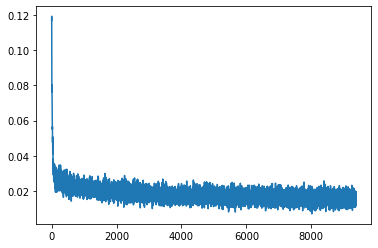

In [ ]:
#|code-fold:true

# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseConditionedUNet(1, 1) # <<< Using our new noise conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_noise_cond = []

# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_noise_cond.append(avg_loss)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

The loss is marginally lower (and only for some runs with this network - you may see a larger effect with the other architectures). There's something I want to note here: A decent network should be trivially capable of seeing whether a given input is super noisy or not. And so this noise conditioning might not be necessary - in fact in tests I've found that it doesn't seem to make any difference! And yet this is used everywhere, largely as an artifact of the historical framing of diffusion models or the way the training objective is set up.

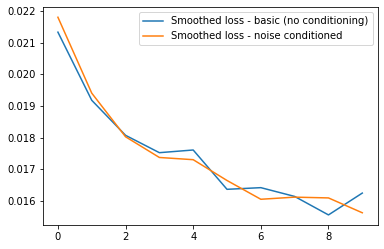

In [ ]:
# Comparing the training curves of the two vairants
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.legend();

Anyway, our sampling loop looks roughly the same as before except now we need to pass a noise_amount to the model at each step. Here I assume it goes linearly from 1 to 0 over the course of sampling but THIS IS NOT NECESSARILY RIGHT. Sampling schemes usually explicity account for the timestep in the update, as we'll see when we look at the DDPM version.

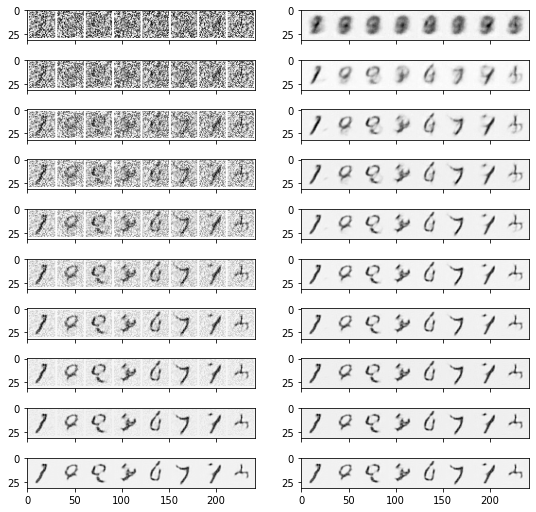

In [ ]:
#|code-fold:true
# Sampling as before, but conditioning on an estimated noise amount:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x, noise_amount) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there # Should it be (pred-x) instead of pred?
    step_history.append(x.detach().cpu()) # Store for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')

Let's make a whle grid of predictions, sampling with more steps:

<matplotlib.image.AxesImage>

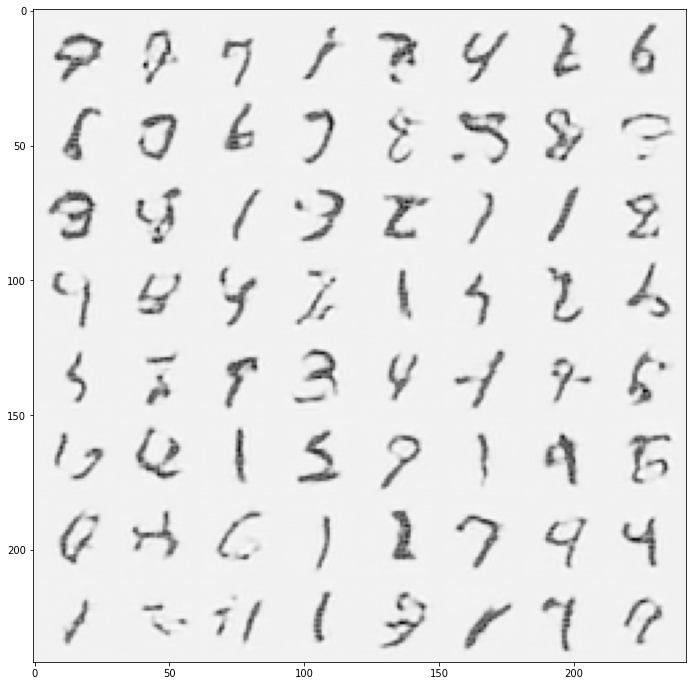

In [ ]:
#|code-fold:true
# Try some at higher steps
n_steps = 20 # Try 2, 5, 10, 50 - how does it affact things?
x = torch.rand(64, 1, 28, 28).to(device)
history = [x.detach().cpu()]

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
    with torch.no_grad():
        pred = net(x, noise_amount)
    mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

## Class Conditioning

Let's give the model even more information to work with:

In [ ]:
#|code-fold:show
class NoiseAndClassConditionedUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_channels) # Map num_classes discrete classes to class_emb_channels numbers
        self.net = BasicUNet(in_channels+1+class_emb_channels, out_channels) # Note input channels = in_channels+1+class_emb_channels

    def forward(self, x, noise_amount, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape
        
        # Get noise_amount the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h)
        
        # And the class cond
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Reshape
        
        # Net input is now x, noise amound and class cond concatenated together
        net_input = torch.cat((x, noise_amount, class_cond), 1)
        return self.net(net_input)
    
# Creating a network
net = NoiseAndClassConditionedUNet(1, 1)

# Now we need x, noise_amount AND y to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount, y).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

And training as before, but now with `y` (the class labels for the batch) as additional conditioning: `pred = net(noisy_x, noise_amount, y.to(device))`

Finished epoch 0. Average of the last 100 loss values: 0.020672
Finished epoch 1. Average of the last 100 loss values: 0.017990
Finished epoch 2. Average of the last 100 loss values: 0.016845
Finished epoch 3. Average of the last 100 loss values: 0.015837
Finished epoch 4. Average of the last 100 loss values: 0.014984
Finished epoch 5. Average of the last 100 loss values: 0.014719
Finished epoch 6. Average of the last 100 loss values: 0.015118
Finished epoch 7. Average of the last 100 loss values: 0.014482
Finished epoch 8. Average of the last 100 loss values: 0.013828
Finished epoch 9. Average of the last 100 loss values: 0.013831


[<matplotlib.lines.Line2D>]

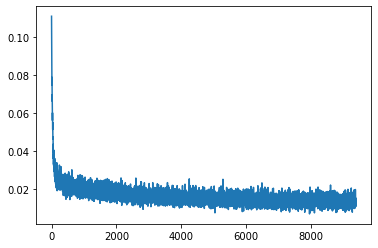

In [ ]:
#|code-fold:true
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseAndClassConditionedUNet(1, 1) # <<< Using our new noise and class conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_class_cond = []

# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount, y.to(device)) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_class_cond.append(avg_loss)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

The reason this is useful is that we can now feed in a set of labels as our conditioning during sampling, and hopefully see those reflected in the outputs:

<matplotlib.image.AxesImage>

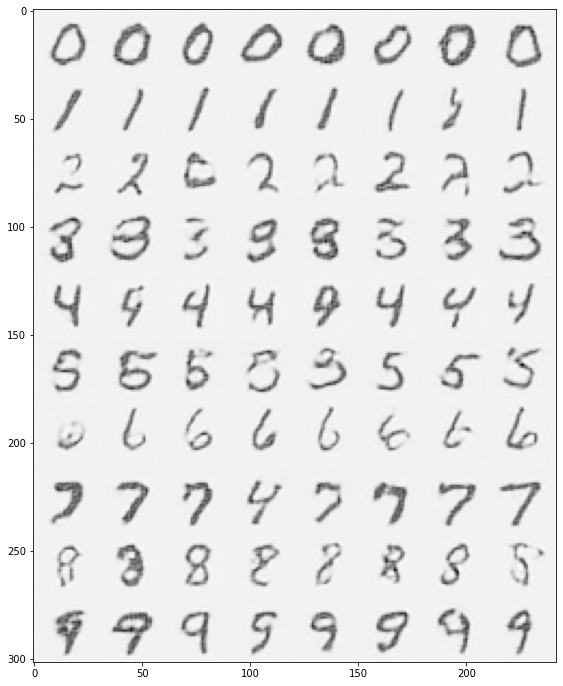

In [ ]:
#|code-fold:true
n_steps = 20
x = torch.rand(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
history = [x.detach().cpu()]

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = net(x, noise_amount, y)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

Knowing what digit it is working on DOES give the model more of a hint, and we see a lower loss than the unconditional version during training:

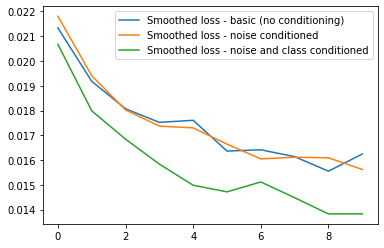

In [ ]:
#|code-fold:true
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.plot(smoothed_losses_class_cond, label='Smoothed loss - noise and class conditioned')
plt.legend();

### What have we learnt, and how much was a lie?

This exercise has hopefully given at least a conceptual understanding of roughly what is going on here. None of the components are optimal, and there is some extra complexity we'll need to address eventually, but it's not a bad place to start. We've identified the key ingredients for training a diffusion model, namely:
- A method for gradually corrupting the data
- A model of some sort that takes in this corrupted data as inputs
- A plan for how much noise to add, and how to reverse the process during sampling.

Turns out nobody does any of these quite like how we did it. When you see a paper or read an explainer notebook on a new diffusion model variant try to see how they do each bit, and dig into why they made those choices.

Questions we haven't (yet) answered:
- Where does the idea of timesteps come in? What does it mean when people talk about discrete vs continuous time formulations?
- What training objectives are used?
- OK but someone mentioned differential equations?
- Something something variance preserving (VP) or variance exploding (VE)???
- What are better ways to sample with these models?
- What is this unet people keep mentioning?
- How do I control this with text?
- How do 'real' implementations feed in the conditioning for noise level/timestep and for things like text?
- Why is this better than a one-shot approach like a GAN?

# DDPM with the Diffusers library

With the first example held in mind, let's look at an implementation of a diffusion model based on [the DDPM paper] and see how it compares to our toy version above:

### The Data

Explain - TODO dataset lib maybe?

In [ ]:
#|output:false
from torchvision import transforms
from datasets import load_dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

image_size = 32
batch_size = 32

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### The Scheduler

In [ ]:
# TODO split out here
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

X shape torch.Size([32, 3, 32, 32])
Noisy X shape torch.Size([32, 3, 32, 32])


<matplotlib.image.AxesImage>

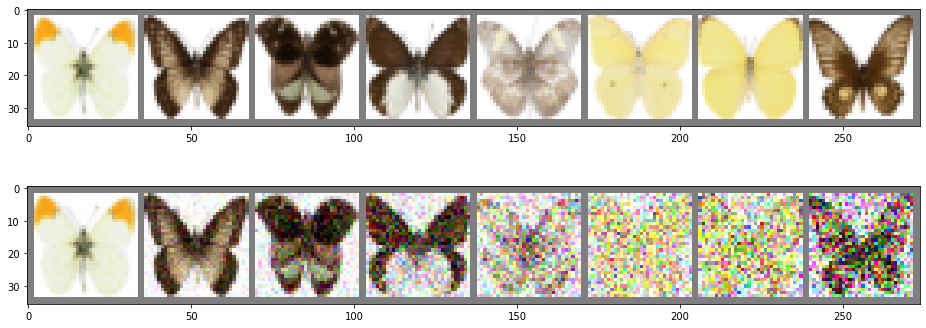

In [ ]:
# Noise a batch of images to view the effect
fig, axs = plt.subplots(2, 1, figsize=(16, 6))
xb = next(iter(train_dataloader))['images'].to(device)
print('X shape', xb.shape)
axs[0].imshow(torchvision.utils.make_grid(xb[:8]).detach().cpu().permute(1, 2, 0)*0.5 + 0.5)

timesteps = torch.linspace(0, 999, batch_size).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8]).clip(-1, 1).detach().cpu().permute(1, 2, 0)*0.5 + 0.5)

## The model

TODO split out here

TODO explain UNETs

TODO mention attention

TODO explore number of parameters

Output shape: torch.Size([32, 3, 32, 32])


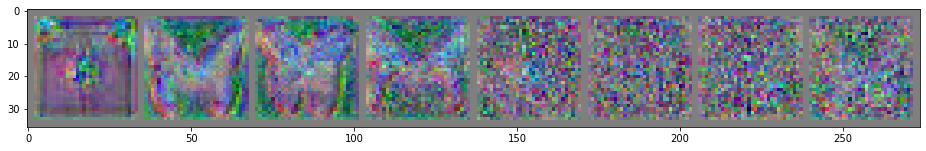

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 64, 128, 128),  # <<< smaller than their eg
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D",  
      ),
)
model.to(device)

# Make sure the shapes work by pushing our noisy batch through
model_output = model(noisy_xb, timestep=timesteps).sample
print('Output shape:', model_output.shape)
fig, axs = plt.subplots(1, 1, figsize=(16, 3))
axs.imshow(torchvision.utils.make_grid(model_output[:8]).clip(-1, 1).detach().cpu().permute(1, 2, 0)*0.5 + 0.5);

In [ ]:
sum([p.numel() for p in model.parameters()]) # Still 7M params!

7134595

## The training loop

As before we will:
- Grab some data
- Noise by random amounts (using `noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)` where timesteps are random ints between 0 and `noise_scheduler.num_train_timesteps`)
- Have the model predict the noise residual (rather than the denoised image) based on the noisy inputs and the timesteps (the latter as conditioning). 
- Cmpute a loss (MSE), backward, update with an optimizer. 



In [ ]:
# Training loop
import torch.nn.functional as F

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

losses = []

for epoch in range(25):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    if (epoch+1)%5 == 0: print(epoch, sum(losses[-len(train_dataloader):])/len(train_dataloader))

4 0.08051558036822826
9 0.05740336223971099
14 0.0568392924615182
19 0.04763124854071066
24 0.04287085105897859


## Sampling

In [ ]:
#|hide
import PIL.Image
import numpy as np
import tqdm
import pdb

def display_sample(sample, text=None):
    # NB: clip to avoid overflows changing the display (issue in diffusers docs)
    image_processed = sample.cpu().permute(0, 2, 3, 1).clip(-1,1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)
    image_pil = PIL.Image.fromarray(image_processed[0])
    if text:
        display(text)
    display(image_pil)

'prev_sample and pred_original_sample at step: 9 (timestep 750)'

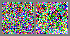

'prev_sample and pred_original_sample at step: 19 (timestep 500)'

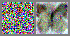

'prev_sample and pred_original_sample at step: 29 (timestep 250)'

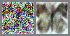

'prev_sample and pred_original_sample at step: 39 (timestep 0)'

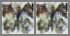

In [ ]:
# Doesn't have to be the same as scheduler we trained with
from diffusers import DDIMScheduler
sampling_scheduler = DDIMScheduler(num_train_timesteps=1000, tensor_format="pt")
sampling_scheduler.set_timesteps(40)
# Sample with this new scheduler
sample = torch.randn(1, 3, 32, 32).to(device)

for i, t in enumerate(sampling_scheduler.timesteps):
    
  # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = sampling_scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 10 == 0:
        # Soon we can do:
        # pred_original_sample = scheduler.step(residual, t, sample).pred_original_sample 
        # But for now we steal code from step:
        # Look at predicted output image if this is the noise (see sampler code for formula)
        alpha_prod_t = sampling_scheduler.alphas_cumprod[t]
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** (0.5) * residual) / alpha_prod_t ** (0.5)

        preview_im = torchvision.utils.make_grid(torch.cat([sample, pred_original_sample], dim=0)).unsqueeze(0)
        display_sample(preview_im, f'prev_sample and pred_original_sample at step: {i} (timestep {t})')

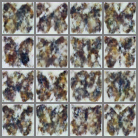

In [ ]:
sampling_scheduler = DDIMScheduler(num_train_timesteps=1000, tensor_format="pt")
sampling_scheduler.set_timesteps(30)
# Sample with this new scheduler
sample = torch.randn(16, 3, 32, 32).to(device)

for i, t in enumerate(sampling_scheduler.timesteps):
    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = sampling_scheduler.step(residual, t, sample).prev_sample

preview_im = torchvision.utils.make_grid(sample, nrow=4).unsqueeze(0)
display_sample(preview_im)

TODO
- Maybe switch dataset back to mnist?
- Visualize noise schedule
- Add noise example even the worst looks like a butterfly wth? Maybe they forgot to .clip() and thought they were adding more noise? TODO check back to the og diffusers example notebook
- Benchmark DDPM vs DCDM better 
- Separate ntebook for DCDM
- W&B logs for a few runs to share (+ report)
- 

# Our 'Toy' Example TO THE MAX

You may be wondering: that toy example, were all those choices terrible? What would this 'naive' corruption method and sampling approach look like if you trained a decent unet model to 'decorrupt' the image? Good news, I made a fastai version and it actually works suprisingly well - and trains much faster than the equivalent DDPM model! 